# Visualizing analyses with fresnel
In this notebook, we simulate a system of tetrahedra, color particles according to their local density, and path-trace the resulting image with [fresnel](https://github.com/glotzerlab/fresnel).

The cell below runs a short [HOOMD-blue](https://github.com/glotzerlab/hoomd-blue/) simulation of tetrahedra using Hard Particle Monte Carlo (HPMC).

In [1]:
import itertools
import numpy as np
import hoomd
import hoomd.hpmc


def make_simple_cubic_snapshot(a, n):
    """Make a snapshot with a simple cubic lattice.

    Args:
        a (float): Lattice spacing
        n (int): Number of particles

    Returns:
        hoomd.Snapshot: The initial system snapshot.
    """
    k = int(np.ceil(n**(1/3)))
    L = k * a
    x = np.linspace(-L / 2, L / 2, k, endpoint=False)
    position = list(itertools.product(x, repeat=3))
    position = position[:n]

    snap = hoomd.Snapshot()
    snap.particles.N = n
    snap.particles.types=['A']
    snap.particles.typeid[:] = [0] * n
    snap.particles.position[:] = position
    snap.configuration.box = [L, L, L, 0, 0, 0]

    return snap


# Create an 8x8x8 simple cubic lattice
sim = hoomd.Simulation(hoomd.device.CPU())
sim.create_state_from_snapshot(make_simple_cubic_snapshot(a=1.5, n=512))
sim.seed = 42

# Create our tetrahedra and configure the HPMC integrator
mc = hoomd.hpmc.integrate.ConvexPolyhedron(default_a=0.1, default_d=0.2)
vertices = [(0.5, 0.5, 0.5), (-0.5, -0.5, 0.5), (-0.5, 0.5, -0.5), (0.5, -0.5, -0.5)]
mc.shape["A"] = dict(vertices=vertices)
sim.operations.integrator = mc

# Run for 5,000 steps
sim.run(5e3)
snap = sim.state.get_snapshot()

/home/tomwalt/mambaforge/envs/freud-examples/lib/python3.10/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


Now we import the modules needed for analysis and visualization.

In [2]:
import fresnel
import freud
import matplotlib.cm
import numpy as np
from matplotlib.colors import Normalize

device = fresnel.Device()

Next, we'll set up the arrays needed for the scene and its geometry. This includes the analysis used for coloring particles.

In [3]:
poly_info = fresnel.util.convex_polyhedron_from_vertices(vertices)
positions = snap.particles.position
orientations = snap.particles.orientation
box = freud.Box.from_box(snap.configuration.box)
ld = freud.density.LocalDensity(3.0, 1.0)
ld.compute(system=snap)
colors = matplotlib.cm.viridis(Normalize()(ld.density))
box_points = np.asarray(
    [
        box.make_absolute(
            [
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [1, 1, 0],
                [1, 1, 0],
                [1, 1, 0],
                [0, 1, 1],
                [0, 1, 1],
                [0, 1, 1],
                [1, 0, 1],
                [1, 0, 1],
                [1, 0, 1],
            ]
        ),
        box.make_absolute(
            [
                [1, 0, 0],
                [0, 1, 0],
                [0, 0, 1],
                [1, 0, 0],
                [0, 1, 0],
                [1, 1, 1],
                [1, 1, 1],
                [0, 1, 0],
                [0, 0, 1],
                [0, 0, 1],
                [1, 1, 1],
                [1, 0, 0],
            ]
        ),
    ]
)

This cell creates the scene and geometry objects to be rendered by `fresnel`.

In [4]:
scene = fresnel.Scene(device)
geometry = fresnel.geometry.ConvexPolyhedron(
    scene,
    poly_info,
    position=positions,
    orientation=orientations,
    color=fresnel.color.linear(colors),
)
geometry.material = fresnel.material.Material(
    color=fresnel.color.linear([0.25, 0.5, 0.9]), roughness=0.8, primitive_color_mix=1.0
)
geometry.outline_width = 0.05
box_geometry = fresnel.geometry.Cylinder(scene, points=box_points.swapaxes(0, 1))
box_geometry.radius[:] = 0.1
box_geometry.color[:] = np.tile([0, 0, 0], (12, 2, 1))
box_geometry.material.primitive_color_mix = 1.0
scene.camera = fresnel.camera.Orthographic.fit(scene, view="isometric", margin=0.1)

First, we preview the scene. (This doesn't use path tracing, and is much faster.)

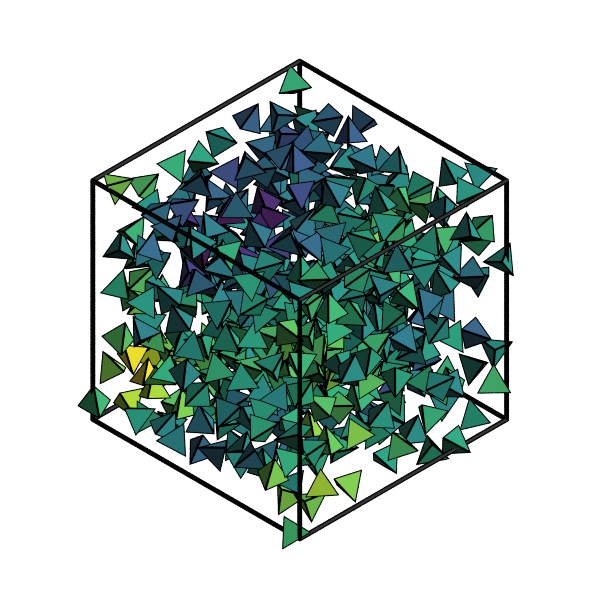

In [5]:
fresnel.preview(scene, anti_alias=True, w=600, h=600)

Finally, we use path tracing for a high quality image. The number of light samples can be increased to reduce path tracing noise.

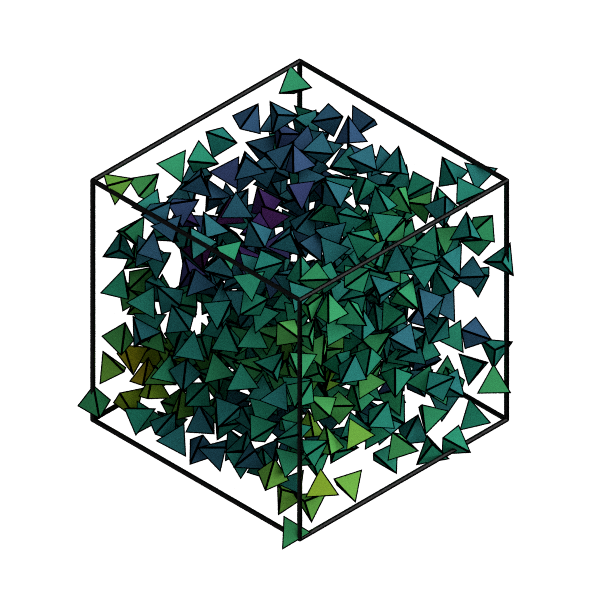

In [6]:
fresnel.pathtrace(scene, light_samples=16, w=600, h=600)